# Assignment 3 - Supervised Learning: model training and evaluation

## *Fides Regina Schwartz*
Netid: fs113

Instructions for all assignments can be found [here](https://github.com/kylebradbury/ids705/blob/master/assignments/_Assignment%20Instructions.ipynb), and is also linked to from the [course syllabus](https://kylebradbury.github.io/ids705/index.html).

Total points in the assignment add up to 90; an additional 10 points are allocated to presentation quality.

# Learning Objectives:
This assignment will provide structured practice to help enable you to...
1. Understand the primary workflow in machine learning: (1) identifying a hypothesis function set of models, (2) determining a loss/cost/error/objective function to minimize, and (3) minimizing that function through gradient descent
2. Understand the inner workings of logistic regression and how linear models for classification can be developed.
3. Gain practice in implementing machine learning algorithms from the most basic building blocks to understand the math and programming behind them to achieve practical proficiency with the techniques
4. Implement batch gradient descent and become familiar with how that technique is used and its dependence on the choice of learning rate
5. Evaluate supervised learning algorithm performance through ROC curves and using cross validation
6. Apply regularization to linear models to improve model generalization performance

# Question 1
## Classification using logistic regression: build it from the ground up
**[60 points]**

This exercise will walk you through the full life-cycle of a supervised machine learning classification problem. Classification problem consists of two features/predictors (e.g. petal width and petal length) and your goal is to predict one of two possible classes (class 0 or class 1). You will build, train, and evaluate the performance of a logistic regression classifier on the data provided. Before you begin any modeling, you'll load and explore your data in Part I to familiarize yourself with it - and check for any missing or erroneous data. Then, in Part II, we will review an appropriate hypothesis set of functions to fit to the data: in this case, logistic regression. In Part III, we will derive an appropriate cost function for the data (spoiler alert: it's cross-entropy) as well as the gradient descent update equation that will allow you to optimize that cost function to identify the parameters that minimize the cost for the training data. In Part IV, all the pieces come together and you will implement your logistic regression model class including methods for fitting the data using gradient descent. Using that model you'll test it out and plot learning curves to verify the model learns as you train it and to identify and appropriate learning rate hyperparameter. Lastly, in Part V you will apply the model you designed, implemented, and verified to your actual data and evaluate and visualize its generalization performance as compared to a KNN algorithm. **When complete, you will have accomplished learning objectives 1-5 above!**

## I. Load, prepare and plot the data

#### (a) i) Load the data

In [1]:
import pandas as pd

Q1 = pd.read_csv(
    "C:\\Users\\dm93\\Documents\\GitHub\\ids705\\assignments\\data\\A3_Q1_data.csv",
    header=0,
)


In [2]:
# look at data
Q1.head()

,x1,x2,y
0,2.553124,0.337757,0
1,-0.877757,0.045790,1
2,-0.903528,0.368076,1
3,-1.532152,-0.863737,1
4,-0.046954,-0.388761,1


Header has been chosen correctly

In [3]:
# Look at shape of data
Q1.shape

(200, 3)

We have 200 rows and 3 columns of data

In [4]:
# Look at type of data
type(Q1)

pandas.core.frame.DataFrame

Data format is pandas dataframe

In [ ]:
# Check for missing values
Q1.isnull().values.any()

There are no missing values

In [5]:
# Look at summary stats
Q1.describe()

,x1,x2,y
count,200.000000,200.000000,200.000000
mean,0.151376,-0.385426,0.485000
std,1.411722,1.217490,0.501029
min,-3.210005,-3.193456,0.000000
25%,-0.912029,-1.341047,0.000000
50%,0.112286,-0.479684,0.000000
75%,1.174400,0.495114,1.000000
max,3.867647,3.103541,1.000000


All columns have 200 rows, the minimum and maximum values for x1 and x2 seem to be in roughly the same range (-3.5 to 4). The mean value of y is ~0.5, so it seems like there's an equal distribution of 0 and 1 classes.

##### ii) Divide your data into a training and testing set where the test set accounts for 30 percent of the data and the training set the remaining 70 percent.

In [6]:
# import everything sklearn
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.model_selection import learning_curve

In [7]:
# Split data into X and y sets
X = Q1.iloc[:, [0,1]]
y = Q1.iloc[:, -1]

In [ ]:
# Check that the split worked
#print(y.head())
print(X.head())

In [8]:
# Use sklearn to split into train and test dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


In [9]:
type(X_train)

pandas.core.frame.DataFrame

##### iii) Plot the training data by class

In [10]:
# import all things plotting
import numpy as np
import scipy as sp
import scipy.spatial
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

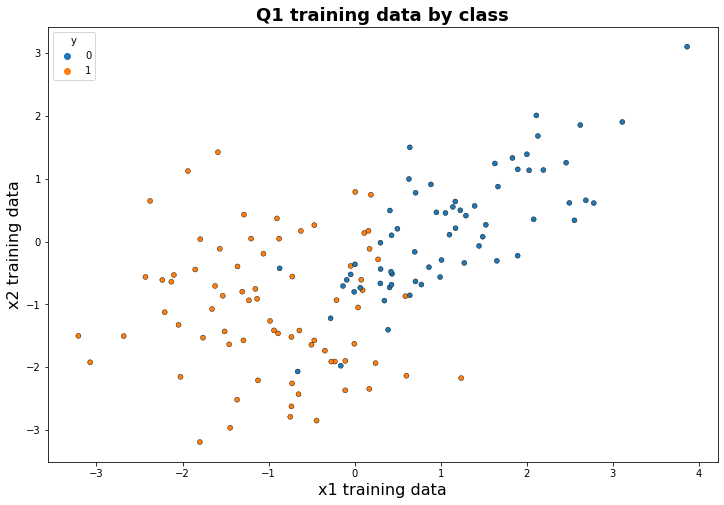

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.scatterplot(
    x=X_train.iloc[:, 0],
    y=X_train.iloc[:, 1],
    hue=y,
    marker="o",
    s=25,
    edgecolor="k",
    ax=ax,
).set_title("Q1 training data by class", fontsize=18, fontweight="bold")
ax.set_xlabel("x1 training data", fontsize=16)
ax.set_ylabel("x2 training data", fontsize=16)
plt.show()


##### iv) Comment on the data: do the data appear separable? May logistic regression be a good choice for these data? Why or why not?

The data does not look completely separable as there is some overlap between the classes around the x1 and x2 0 variables. A logistic regression would probably be able to produce reasonable predictions though, because the decision boundary could be visualized as a diagonal between the two classes and mostly separate the classes.

#### (b) Do the data require any preprocessing due to missing values, scale differences (e.g. different ranges of values), etc.? If so, how did you handle these issues?

There are no missing values in the dataset and the minimum and maximum values for x1 and x2 seem to be in roughly the same range (-3.5 to 4). The mean value of y is ~0.5, so it seems like there's an equal distribution of 0 and 1 classes.

### II. Stating the hypothesis set of models to evaluate (we'll use logistic regression)

Given that our data consists of two features, our logistic regression problem will be applied to a two-dimensional feature space. Recall that our logistic regression model is:

$$f(\mathbf{x}_i,\mathbf{w})=\sigma(\mathbf{w}^{\top} \mathbf{x}_i)$$

where the sigmoid function is defined as $\sigma(x) = \dfrac{e^x}{1+e^{x}}= \dfrac{1}{1+e^{-x}}$. Also, since this is a two-dimensional problem, we define $\mathbf{w}^{\top} \mathbf{x}_i = w_0 x_{i,0} + w_1 x_{i,1} + w_2 x_{i,2}$ and here, $\mathbf{x}_i=[x_{i,0}, x_{i,1}, x_{i,2}]^{\top}$, and $x_{i,0} \triangleq 1$

Remember from class that we interpret our logistic regression classifier output (or confidence score) as the conditional probability that the target variable for a given sample $y_i$ is from class "1", given the observed features, $\mathbf{x}_i$. For one sample, $(y_i, \mathbf{x}_i)$, this is given as:

$$P(Y=1|X=\mathbf{x}_i) = f(\mathbf{x}_i,\mathbf{w})=\sigma(\mathbf{w}^{\top} \mathbf{x}_i)$$

In the context of maximizing the likelihood of our parameters given the data, we define this to be the likelihood function $L(\mathbf{w}|y_i,\mathbf{x}_i)$, corresponding to one sample observation from the training dataset.

*Aside: the careful reader will recognize this expression looks different from when we talk about the likelihood of our data given the true class label, typically expressed as $P(x|y)$, or the posterior probability of a class label given our data, typically expressed as $P(y|x)$. In the context of training a logistic regression model, the likelihood we are interested in is the likelihood function of our logistic regression **parameters**, $\mathbf{w}$. It's our goal to use this to choose the parameters to maximize the likelihood function.*

**No output is required for this section - just read and use this information in the later sections.**

## III. Find the cost function that can be used to choose the model parameters $\mathbf{w}$ that best fit the training data

**(c)** What is the likelihood function that corresponds to all the $N$ samples in our training dataset that we will wish to maximize? Unlike the likelihood function written above which gives the likelihood function for a *single training data pair* $(y_i, \mathbf{x}_i)$, this question asks for the likelihood function for the *entire training dataset* $\{(y_1, \mathbf{x}_1), (y_2, \mathbf{x}_2), ..., (y_N, \mathbf{x}_N)\}$. 

Sigmoid function:
$$
\begin{aligned}
L(w|y, X) = P(y_1, y_2, ..., y_N|x_1, x_2, ...,x_N) \\
&= {\prod_{i=1}^{N} P(y_i|x_i)} \\
&= {\prod_{i=1}^{N} [\sigma(w^{\top}x_i)]^{y_i} [1-\sigma(w^{\top}x_i)]^{1-y_i}}
\end{aligned}
$$

Likelihood function for entire training dataset:
$$
\boxed{L(w|y, X) = 
\prod_{i=1}^{N} [\sigma(w^{\top}x_i)]^{y_i} [1-\sigma(w^{\top}x_i)]^{1-y_i}}
$$

**(d)** Since a logarithm is a monotonic function, maximizing the $f(x)$ is equivalent to maximizing $\ln [f(x)]$. Express the likelihood from the last question as a cost function of the model parameters, $C(\mathbf{w})$; that is the negative of the logarithm of the likelihood.

Express likelihood as a cost function by taking negative log on both sides of the equation: 

${\mathbf{}}C(\mathbf{w}) = -log \begin{bmatrix}
\prod_{i=1}^{N} [\sigma(w^{\top}x_i)]^{y_i} [1-\sigma(w^{\top}x_i)]^{1-y_i}
\end{bmatrix}$

$ = 
{\mathbf{-\left[\sum_{i=1}^{N} \log[\sigma(w^{\top}x_i)]^{y_i} [1-\sigma(w^{\top}x_i)]^{1-y_i}\right]}}$

$ = 
{\mathbf{-\left[\sum_{i=1}^{N}y_i \log(\sigma(w^{\top}x_i)) + (1  -y_i)log[1-\sigma(w^{\top}x_i))\right]}}$

Define the cost function:
$$\boxed{{\mathbf{}}C(\mathbf{w}) = -\left[\sum_{i=1}^{N}y_i \log(\sigma(w^{\top}x_i)) + (1 - y_i) \log(1-\sigma(w^{\top}x_i))\right]}$$

The average cost function (normalized to sample size) is:
$$\boxed{{\mathbf{}}C(\mathbf{w}) = -\frac{1}{N} \left[\sum_{i=1}^{N}y_i \log(\sigma(w^{\top}x_i)) + (1 - y_i) \log(1-\sigma(w^{\top}x_i))\right]}$$

**(e)** Calculate the gradient of the cost function with respect to the model parameters $\nabla_{\mathbf{w}}C(\mathbf{w})$. Express this in terms of the partial derivatives of the cost function with respect to each of the parameters, e.g. $\nabla_{\mathbf{w}}C(\mathbf{w}) = \left[\dfrac{\partial C}{\partial w_0}, \dfrac{\partial C}{\partial w_1}, \dfrac{\partial C}{\partial w_2}\right]$. 

First, take the partial derivatives of each weight:

$$
\begin{aligned}
\dfrac{\partial C}{\partial w_0} &= \sum_{i=1}^{N}x_{i, 0}[y_i(1 - \sigma(w^{\top}x_i)) - (1-y_i)\sigma(w^{\top}x_i)] \\
&= \sum_{i=1}^{N}x_{i,0}[\sigma(w^{\top}x_i) - y_i]
\end{aligned}
$$

$$
\begin{aligned}
\dfrac{\partial C}{\partial w_1} &= \sum_{i=1}^{N}x_{i, 1}[y_i(1 - \sigma(w^{\top}x_i)) - (1-y_i)\sigma(w^{\top}x_i)] \\
&= \sum_{i=1}^{N}x_{i,1}[\sigma(w^{\top}x_i) - y_i]
\end{aligned}
$$

$$
\begin{aligned}
\dfrac{\partial C}{\partial w_2} &= \sum_{i=1}^{N}x_{i, 2}[y_i(1 - \sigma(w^{\top}x_i)) - (1-y_i)\sigma(w^{\top}x_i)] \\
&= \sum_{i=1}^{N}x_{i,2}[\sigma(w^{\top}x_i) - y_i]
\end{aligned}
$$

Second, express them all together like this:
$$
\begin{aligned}
\nabla_{\mathbf{w}}C(\mathbf{w}) &= \left[\dfrac{\partial C}{\partial w_0}, \dfrac{\partial C}{\partial w_1}, \dfrac{\partial C}{\partial w_2}\right] \\
&= \left[\sum_{i=1}^{N}x_{i, 0}[\sigma(w^{\top}x_i) - y_i], \sum_{i=1}^{N}x_{i, 1}[\sigma(w^{\top}x_i) - y_i],\sum_{i=1}^{N}x_{i, 2}[\sigma(w^{\top}x_i) - y_i]\right]\end{aligned}
$$

Third, combine into one step:
$$\nabla_{\mathbf{w}}C(\mathbf{w}) = \left[\sum_{i=1}^{N}[\sigma(w^{\top}x_i) - y_i], \sum_{i=1}^{N}x_]{i,1}[\sigma(w^{\top}x_i) - y_i], \sum_{i=1}^{N}x_{i, 2}[\sigma(w^{\top}x_i) - y_i]\right]$$

To simplify notation, please use $\mathbf{w}^{\top}\mathbf{x}$ instead of writing out $w_0 x_{i,0} + w_1 x_{i,1} + w_2 x_{i,2}$ when it appears each time (where $x_{i,0} = 1$ for all $i$). You are also welcome to use $\sigma()$ to represent the sigmoid function. Lastly, this will be a function the features, $x_{i,j}$ (with the first index in the subscript representing the observation and the second the feature; targets, $y_i$; and the logistic regression model parameters, $w_j$.

**(f)** Write out the gradient descent update equation. This should clearly express how to update each weight from one step in gradient descent $w_j^{(k)}$ to the next $w_j^{(k+1)}$.  There should be one equation for each model logistic regression model parameter (or you can represent it in vectorized form). Assume that $\eta$ represents the learning rate.

The following are the gradient descent update functions for each $w_i$:

$$w_0^{(k+1)} = w_0^{(k)} - \eta\dfrac{\partial C}{\partial w_0^{(k)}}$$

$$w_1^{(k+1)} = w_1^{(k)} - \eta\dfrac{\partial C}{\partial w_1^{(k)}}$$

$$w_2^{(k+1)} = w_2^{(k)} - \eta\dfrac{\partial C}{\partial w_2^{(k)}}$$


If we want to generalize this, it looks like this:
$$\mathbf{w}_j^{(k+1)} = \mathbf{w}_j^{(k)} - \eta \nabla_w C{\mathbf{w}_j^{(k)}}$$

### IV. Implement gradient descent and your logistic regression algorithm

**(g)** Implement your logistic regression model. 
You are provided with a template, below, for a class with key methods to help with your model development. It is modeled on the Scikit-Learn convention. For this, you only need to create a version of logistic regression for the case of two feature variables (i.e. two predictors).

This structure is strongly encouraged; however, you're welcome to adjust this to your needs (adding helper methods, modifying parameters, etc.).

In [54]:
# Check whether y_train is pandas dataframe or numpy array
y.shape
#type(y_train)

(200,)

In [ ]:
# turn into numpy array
y_train = y_train.values

In [14]:
y_test = y_test.values

In [55]:
import random

# Logistic regression class
class Logistic_regression:
    # Class constructor
    def __init__(self):
        self.w = None  # logistic regression weights
        self.saved_w = []  # Since this is a small problem, we can save the weights
        #  at each iteration of gradient descent to build our
        #  learning curves
        # returns nothing
    print("here1")

    # Method for calculating the sigmoid function of w^T X for an input set of weights
    def sigmoid(self, X, w):
        sigma = 1 / (1 + np.exp(-w.reshape(1, -1) @ X.T)).T  # to get Nx1
        return sigma  # returns the value of the sigmoid
    print("here2")

    # Cost function for an input set of weights
    def cost(self, X, y, w):
        cost = -(
            (y * np.log(self.sigmoid(X, w)) + (1 - y) * np.log(1 - self.sigmoid(X, w)))
        )
        cost_avg = np.mean(cost)
        return cost_avg  # returns the average cross entropy cost
    print("here3")

    # Update the weights in an iteration of gradient descent
    def gradient_descent(self, X, y, w, lr):
        pred = self.sigmoid(X, w)
        # print(y)
        y = y.reshape((-1, 1))  # make y a column vector
        d = lr * np.sum(np.dot(X.T, (pred - y)))
        self.w -= d
        delta = np.linalg.norm(d)  # updated weights
        # returns s scalar of the magnitude of the Euclidean norm
        #  of the change in the weights during one gradient descent step
        return delta
    print("here4")

    # Fit the logistic regression model to the data through gradient descent
    def fit(self, X, y, w, lr, delta_thresh=1e-6, max_iter=5000, verbose=False):
        # Note the verbose flag enables you to print out the weights at each iteration
        #  (optional - but may help with one of the questions)
        self.w = w
        X = self.prepare_x(X)
        iterations = 0
        update_norm = 1

        while (iterations < max_iter) and (update_norm > delta_thresh):
            update_vec = self.gradient_descent(X, y, w, lr)
            w_init[:, None] -= update_vec
            self.w = w_init
            self.saved_w.append(w_init.copy())
            iterations += 1
            if verbose:
                print(self.w)  # returns nothing
    print("here5")

    # Use the trained model to predict the confidence scores (prob of positive class in this case)
    def predict_proba(self, X):
        return self.sigmoid(
            X, self.w
        )  # returns the confidence score for the each sample
    print("here6")

    # Use the trained model to make binary predictions
    def predict(self, X, thresh=0.5):
        z = self.predict_proba(self.X)
        Y = np.where(z > 0.5, 1, 0)  # returns a binary prediction for each sample
        return Y
    print("here7")

    # Stores the learning curves from saved weights from gradient descent
    def learning_curve(self, X, y):
        lr = []
        for i in range(0, len(self.saved_w)):
            pass  # returns the value of the cost function from each step in gradient descent
        #  from the last model fitting process
        return lr
    print("here8")

    # Appends a column of ones as the first feature to account for the bias term
    def prepare_x(self, X):
        return np.concatenate(
            [np.ones((X.shape[0], 1)), X], axis=1
        )  # returns the X with a new feature of all ones (a column that is the new column 0)
    print("here9")


here1
here2
here3
here4
here5
here6
here7
here8
here9


**(h)** Choose a learning rate and fit your model.
- What is the impact that the different values of learning has on the speed of the process and the results? 
- Of the options explored, what learning rate do you prefer and why?
- Use your chosen learning rate for the remainder of this problem.

**h.1** Choose a learning rate and fit your model. Run this process for a really big learning rate for this problem: $10^0$. Look at the weights that the fitting process generates over the first 50 iterations and how they change. You may simply print these first 50 iterations as output or plot them. What happens and why?

In [56]:
import random
model1 = Logistic_regression()
w_init = np.array([random.random() for i in range(3)])
model1.fit(X_train, y_train, w_init, lr=10 ** 0, verbose=False)
model1.saved_w
model1.learning_curve(X_train, y_train)
X = model1.prepare_x(X_train)
print(X[0:51])


C:\Users\dm93\AppData\Local\Temp/ipykernel_24208/1561063920.py:16: RuntimeWarning: overflow encountered in exp
  sigma = 1 / (1 + np.exp(-w.reshape(1, -1) @ X.T)).T  # to get Nx1


[[ 1.         -2.2349171  -0.61116786]
 [ 1.          1.17152228  0.21263129]
 [ 1.         -0.2306295  -1.91130248]
 [ 1.          0.17293932 -0.11606444]
 [ 1.         -0.88969689 -1.46245477]
 [ 1.         -0.13570049 -0.70794549]
 [ 1.         -2.04611013 -1.32600425]
 [ 1.          2.49421234  0.6154757 ]
 [ 1.          1.16906303  0.6371365 ]
 [ 1.         -1.06010662 -0.19335385]
 [ 1.          0.30079174 -0.43834552]
 [ 1.          0.88546849  0.90988618]
 [ 1.          0.42775399 -0.68637783]
 [ 1.          1.65198293 -0.30742685]
 [ 1.          1.00864234 -0.29469849]
 [ 1.          0.00654375  0.7901501 ]
 [ 1.         -1.22843182 -0.93644305]
 [ 1.          0.94941142  0.46481336]
 [ 1.          0.86281744 -0.40864837]
 [ 1.         -1.44661165 -2.96626949]
 [ 1.         -0.90352823  0.36807628]
 [ 1.          2.11043016  2.00874587]
 [ 1.          0.43424396 -0.51521493]
 [ 1.         -0.73453929 -2.62542766]
 [ 1.         -1.29243919 -1.5743215 ]
 [ 1.          1.22731385

The weights are increasing and then decrease again (oscillate) as the algorithm starts overfitting and then the regularization method kicks in.

**h.2** Show the learning curves for the gradient descent process for learning rates of $\{10^{-2}, 10^{-4}, 10^{-6}\}$. For each learning rate plot the learning curves by plotting **both the training and test data average cost** as a function of each iteration of gradient descent.

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve

# Plot number of iterations per learning rate 

# Initialize custom logistic regression class
log_reg_model = Logistic_regression()

# Fit the model
log_reg_model.fit(X_train, y_train, 0.01, 10, True)


In [58]:
# Train logistic regression model
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf.predict(X_train.iloc[:2, :])

# Get predicted probabilities logistic regression training data
y_pred_proba_logreg_train = clf.predict_proba(X_train.iloc[:2, :])
#print("here1")

# get score on training data
train_scores = clf.score(X_train, y_train)
print(train_scores)


0.8642857142857143


In [59]:
# Get predictions for test data
clf.predict(X_test.iloc[:2, :])

# Get predicted probabilities logistic regression test data
y_pred_proba_logreg_test = clf.predict_proba(X_test.iloc[:2, :])

# get score on testing data
test_scores = clf.score(X_test, y_test)
print(test_scores)

0.9


In [ ]:
# Calculate training and test mean and std
train_mean = np.mean(train_scores)
train_std = np.std(train_scores)
test_mean = np.mean(test_scores)
test_std = np.std(test_scores)

# Plot the learning curve
plt.plot(
    X_train,
    train_mean,
    color="blue",
    marker="o",
    markersize=5,
    label="Training Accuracy",
)
plt.fill_between(
    X_train,
    train_mean + train_std,
    train_mean - train_std,
    alpha=0.15,
    color="blue",
)
plt.plot(
    X_train,
    test_mean,
    color="green",
    marker="+",
    markersize=5,
    linestyle="--",
    label="Validation Accuracy",
)
plt.fill_between(
    X_train, test_mean + test_std, test_mean - test_std, alpha=0.15, color="green"
)
plt.title("Learning Curve")
plt.xlabel("Training Data Size")
plt.ylabel("Model accuracy")
plt.grid()
plt.legend(loc=4)
plt.show()


**h.3** What is the impact that the different values of learning has on the speed of the process and the results?

The learning rate has an influence on the cost, which oscillates, so a high value for learning rate can lead to a long lag time until convergence. The results may be influenced by the learning rate, too, as too high a learning rate can result in overfitting and thus worse results on the test set.

**h.4** Of the options explored, what learning rate do you prefer and why?

The best learning rate would be 0.1, as it converges relatively fast and produces good results. A much higher rate takes longer to converge and a much lower rate produces worse results.

### V. Evaluate your model performance through cross validation

**(i)** Test the performance of your trained classifier using K-folds cross validation resampling technique. The scikit-learn package [StratifiedKFolds](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) may be helpful. 
- Train your logistic regression model and a K-Nearest Neighbor classification model with $k=7$ nearest neighbors.
- Using the trained models, make two plots corresponding to each model (logistic regression and KNN): one with the training data, and one for the test data. On each plot, include the decision boundary resulting from your trained classifier.
- Produce a Receiver Operating Characteristic curve (ROC curve) that represents the performance from cross validated performance evaluation for each classifier (your logistic regression model and the KNN model, with $k=7$ nearest neighbors). For the cross validation, use $k=10$ folds. 
  - Plot these curves on the same set of axes to compare them
  - On the ROC curve plot, also include the chance diagonal for reference (this represents the performance of the worst possible classifier). This is represented as a line from $(0,0)$ to $(1,1)$.
  - Calculate the Area Under the Curve for each model and include this measure in the legend of the ROC plot.
- Comment on the following:
  - What is the purpose of using cross validation for this problem?
  - How do the models compare in terms of performance (both ROC curves and decision boundaries) and which model (logistic regression or KNN) would you select to use on previously unseen data for this problem and why?

**i.1** Train log regression model and a KNN with k = 7.

In [61]:
type(X_train)
X_train.shape
y_train.shape

(140,)

In [62]:
# Implement KNN using sklearn for training data
knn_train = KNeighborsClassifier(n_neighbors=7)

# Fit KNN
knn_train.fit(X_train, y_train)

# Predict
y_hat_train = knn_train.predict(X_train)

# Get predicted probabilities
y_pred_proba_knn_train = knn_train.predict_proba(X_train)[::, 1]

# Get false and true positive rate
fpr_knn_train, tpr_knn_train, _ = metrics.roc_curve(y_train, y_pred_proba_knn_train)

# Get area under the curve
auc_knn_train = np.round(metrics.roc_auc_score(y_train, y_pred_proba_knn_train), 3)

# Get precision and recall
precision_knn_train, recall_knn_train, _ = metrics.precision_recall_curve(
    y_train, y_pred_proba_knn_train
)


In [63]:
# Implement KNN using sklearn for test data
knn_test = KNeighborsClassifier(n_neighbors=7)

# Fit KNN
knn_test.fit(X_test, y_test)

# Predict
y_hat_test = knn_test.predict(X_test)

# Get predicted probabilities
y_pred_proba_knn_test = knn_test.predict_proba(X_test)[::, 1]

# Get false and true positive rate
fpr_knn_test, tpr_knn_test, _ = metrics.roc_curve(y_test, y_pred_proba_knn_test)

# Get area under the curve
auc_knn_test = np.round(metrics.roc_auc_score(y_test, y_pred_proba_knn_test), 3)

# Get precision and recall
precision_knn_test, recall_knn_test, _ = metrics.precision_recall_curve(
    y_test, y_pred_proba_knn_test
)


C:\Users\dm93\miniconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [64]:
print(auc_knn_train)
print(auc_knn_test)


0.967
0.957


**i.2** Make two plots for each model (test and train each) with decision boundary (4 plots total)

Plot 1 - Logistic regression on training data

C:\Users\dm93\miniconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


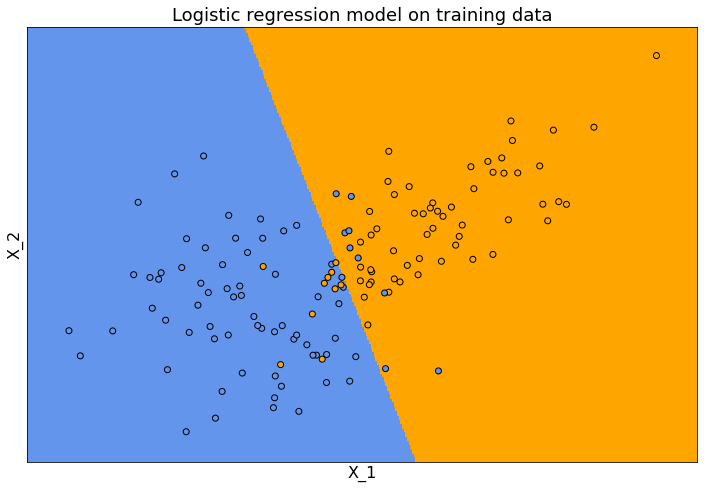

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression
from sklearn import datasets

h = 0.02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(["orange", "cyan", "cornflowerblue"])
cmap_bold = ["darkorange", "darkblue"]

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X_train.iloc[:, 0].min() - 0.5, X_train.iloc[:, 0].max() + 0.5
y_min, y_max = X_train.iloc[:, 1].min() - 0.5, X_train.iloc[:, 1].max() + 0.5

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(12, 8))
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(
    X_train.iloc[:, 0],
    X_train.iloc[:, 1],
    c=y_train,
    edgecolor="black",
    cmap=cmap_light,
)
plt.xlabel("X_1", fontsize=16)
plt.ylabel("X_2", fontsize=16)
plt.title("Logistic regression model on training data", fontdict={"fontsize": 18})
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()


Plot 2 - Logistic regression on test data

C:\Users\dm93\miniconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


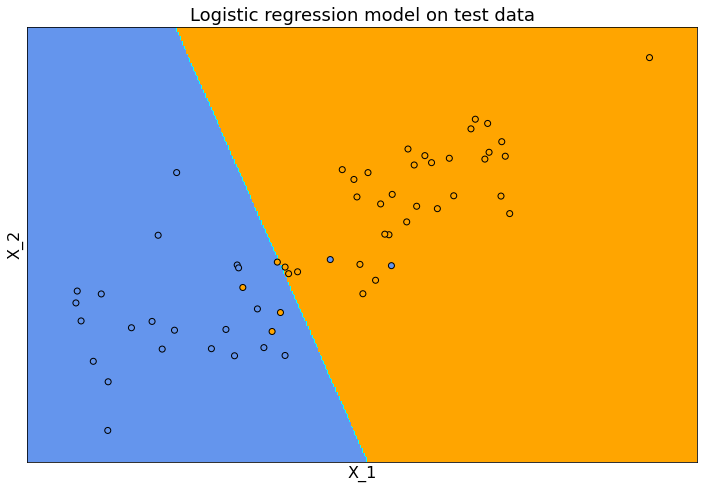

In [38]:
h = 0.02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(["orange", "cyan", "cornflowerblue"])
cmap_bold = ["darkorange", "darkblue"]

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X_test.iloc[:, 0].min() - 0.5, X_test.iloc[:, 0].max() + 0.5
y_min, y_max = X_test.iloc[:, 1].min() - 0.5, X_test.iloc[:, 1].max() + 0.5

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(12, 8))
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
plt.contourf(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(
    X_test.iloc[:, 0], X_test.iloc[:, 1], c=y_test, edgecolor="black", cmap=cmap_light
)
plt.xlabel("X_1", fontsize=16)
plt.ylabel("X_2", fontsize=16)
plt.title("Logistic regression model on test data", fontdict={"fontsize": 18})

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()


Plot 3 - KNN (K=7) on training data

C:\Users\dm93\miniconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


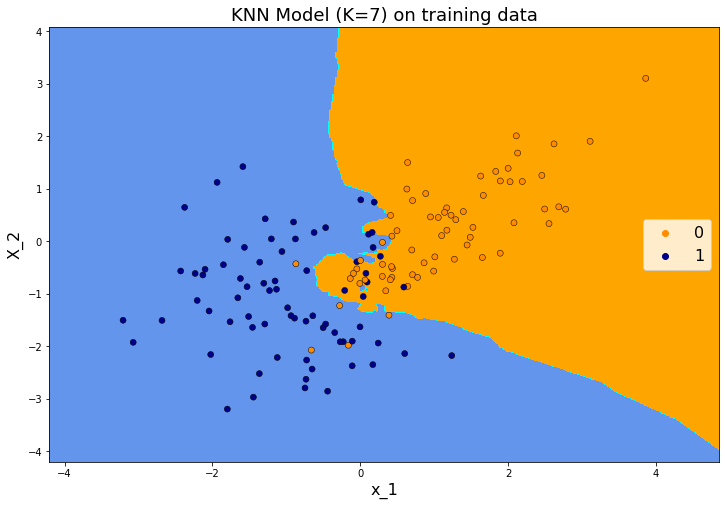

In [39]:
# nearest neighbour = 7

h = 0.02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(["orange", "cyan", "cornflowerblue"])
cmap_bold = ["darkorange", "darkblue"]

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X_train.iloc[:, 0].min() - 1, X_train.iloc[:, 0].max() + 1
y_min, y_max = X_train.iloc[:, 1].min() - 1, X_train.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = knn_train.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12, 8))
plt.contourf(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
sns.scatterplot(
    x=X_train.iloc[:, 0],
    y=X_train.iloc[:, 1],
    hue=y_train,
    palette=cmap_bold,
    alpha=1.0,
    edgecolor="black",
)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("KNN Model (K=7) on training data", fontsize=18)
plt.xlabel("x_1", fontsize=16)
plt.ylabel("X_2", fontsize=16)
plt.legend(loc="right", fontsize=16)
plt.show()


Plot 4 - KNN (K=7) on test data

C:\Users\dm93\miniconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


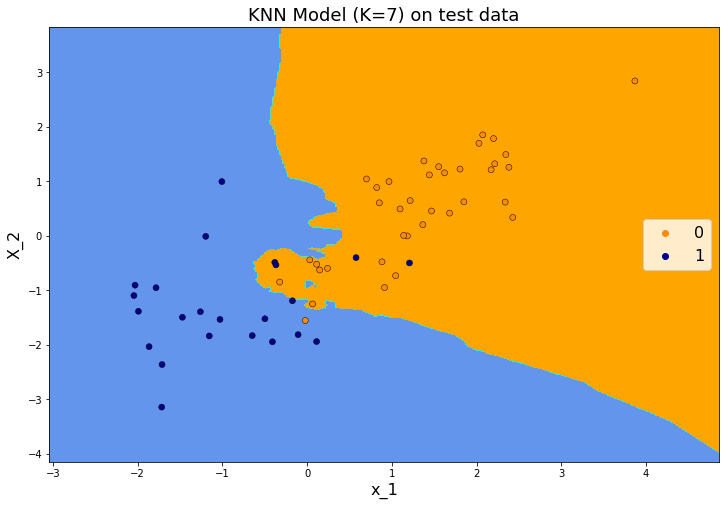

In [40]:
h = 0.02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(["orange", "cyan", "cornflowerblue"])
cmap_bold = ["darkorange", "darkblue"]

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X_test.iloc[:, 0].min() - 1, X_test.iloc[:, 0].max() + 1
y_min, y_max = X_test.iloc[:, 1].min() - 1, X_test.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = knn_train.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12, 8))
plt.contourf(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
sns.scatterplot(
    x=X_test.iloc[:, 0],
    y=X_test.iloc[:, 1],
    hue=y_test,
    palette=cmap_bold,
    alpha=1.0,
    edgecolor="black",
)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("KNN Model (K=7) on test data", fontsize=18)
plt.xlabel("x_1", fontsize=16)
plt.ylabel("X_2", fontsize=16)
plt.legend(loc="right", fontsize=16)
plt.show()


**i.3** Produce ROC curve, use k = 10 folds for cross validation, plot on the same axes + chance diagonal + AUC in legend

In [41]:
type(y_test)
y_test.shape

(60,)

In [66]:
y_test = y_test.reshape(-1, 1)

In [ ]:
# Get predicted probabilities
y_pred_proba_log_reg_test = clf.predict_proba(y_test)

# Get false and true positive rate
fpr_logreg_test, tpr_logreg_test, _ = metrics.roc_curve(y_test, y_pred_proba_logreg_test)

# Get area under the curve
auc_logreg_test = np.round(metrics.roc_auc_score(y_test, y_pred_proba_logreg_test), 3)

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

# k = 10 folds cross validation with ROC curves
cv = StratifiedKFold(n_splits=10)

# set up arrays for scores to go into KNN
y_scores_knn = np.array([])
y_pred_knn = np.array([])
y_true_knn = np.array([])

# set up arrays for scores to go into logistic regression
y_scores_logreg = np.array([])
y_pred_logreg = np.array([])
y_true_logreg = np.array([])

# Make predictions for each of the folds
for i, (train_index, test_index) in enumerate(cv.split(X_train, y_train)):
    X_train_cv = X[train_index]
    y_train_cv = y[train_index]
    X_test_cv = X[test_index]
    y_test_cv = y[test_index]

    # Fit KNN on training data as before
    knn = KNeighborsClassifier(n_neighbors=7, n_jobs=-1)
    knn.fit(X_train_cv, y_train_cv)
    y_scores_knn = np.concatenate((y_scores_knn, knn.predict_proba(X_test_cv)[:, 1]))
    y_pred_knn = np.concatenate((y_pred_knn, knn.predict(X_test_cv)))
    y_true_knn = np.concatenate((y_true_knn, y_test_cv))

    # Fit the logistic regression model as before
    logreg = Logistic_regression()
    x_train_cv = logreg.prepare_x(X_train_cv)
    x_test_cv = logreg.prepare_x(X_test_cv)
    logreg.fit(x_train_cv, y_train_cv, 1, lr=10)
    y_scores_logreg = np.concatenate(
        y_scores_logreg, logreg.predict_proba(x_test_cv).ravel()
    )
    y_pred_logreg = np.concatenate((y_pred_logreg, logreg.predict(x_test_cv)))
    y_true_logreg = np.concatenate((y_true_logreg, y_test_cv))

fpr_knn, tpr_knn, _ = roc_curve(y_true_knn, y_scores_logreg)
#roc_auc_logreg = auc(fpr_logreg_test, tpr_logreg_test)
roc_auc_knn = auc(fpr_knn, tpr_knn)

fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(
    fpr_knn,
    tpr_knn,
    label="AUC for KNN = %0.2f" % auc_knn_test,
    alpha=0.75,
    linewidth=3,
)
plt.plot(
    fpr_logreg_test,
    tpr_logreg_test,
    label="AUC for logistic regression = %0.2f" % auc_logreg_test,
    linewidth=3,
)
plt.plot([0, 1], [0, 1], color="lightgray", ls="--", label="Random Guess")
ax.legend(["Logistic Regression AUC = {0:.2f}".format(roc_auc_knn), "KNN AUC = {0:.2f}".format(roc_auc_knn)], loc="right")
ax.set_title(
    "ROC curves for logistic regression and KNN", fontsize=18, fontweight="bold"
)
ax.set_xlabel("False Positive Rate", fontsize=16)
ax.set_ylabel("True Positive Rate", fontsize=16)

plt.show()


**i.4** What is the purpose of cross validation for this? How do models compare in terms of performance and which model would you select for this problem, and why?

Based on the plots I produced, it looks like the KNN produces a slightly better class separation for the test set with only one point of class 0 mis-classified and four points of class 1 misclassified, while the logistic regression misclassified four points of class 0 and two points of class 1. The logistic regression flattens the input but is not able to capture the more intricate patterns, while the KNN is more flexible in catching those patterns. Ideally, cross-validation would turn this into a measurable output in terms of showing better ROC curves for one of the models.

# Question 2

## Digits classification
**[30 points]**

*An exploration of regularization, imbalanced classes, ROC and PR curves*

The goal of this exercise is to apply your supervised learning skills on a very different dataset: in this case, image data.

Start by loading your dataset from the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) of handwritten digits, using the code provided below. MNIST has a training set of 60,000 examples, and a test set of 10,000 examples. The digits have been size-normalized and centered in a fixed-size image.

In [71]:
# Load the MNIST Data
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Set this to True to download the data for the first time and False after the first time 
#   so that you just load the data locally instead
download_data = False

if download_data:
    # Load data from https://www.openml.org/d/554
    X, y = fetch_openml('mnist_784', return_X_y=True, as_frame=False)
    
    # Adjust the labels to be '1' if y==3, and '0' otherwise
    y[y!='3'] = 0
    y[y=='3'] = 1
    y = y.astype('int')
    
    # Divide the data intro a training and test split
    Mnist_X_train, Mnist_X_test, Mnist_y_train, Mnist_y_test = train_test_split(X, y, test_size=1/7, random_state=88)
    
    file = open('tmpdata', 'wb')
    pickle.dump((Mnist_X_train, Mnist_X_test, Mnist_y_train, Mnist_y_test), file)
    file.close()
else:
    file = open('tmpdata', 'rb')
    Mnist_X_train, Mnist_X_test, Mnist_y_train, Mnist_y_test = pickle.load(file)
    file.close()

In [72]:
# Look at data structure
print(
    f"The shape of the X_train dataset is: {Mnist_X_train.shape}. It seems to be loaded as expected"
)
print(
    f"The shape of the y_train dataset is: {Mnist_y_train.shape}. It seems to be loaded as expected"
)
# print(type(Mnist_X_train))
# print (type(Mnist_y_train))


The shape of the X_train dataset is: (60000, 784). It seems to be loaded as expected
The shape of the y_train dataset is: (60000,). It seems to be loaded as expected


Your goal is to classify whether or not an example digit is a 3. Your binary classifier should predict $y=1$ if the digit is a 3, and $y=0$ otherwise. Create your dataset by transforming your labels into a binary format (3's are class 1, and all other digits are class 0). 

#### (a) Plot 10 examples of each class from the training dataset

Text(0.5, 0.98, 'Random sample images of class 1')

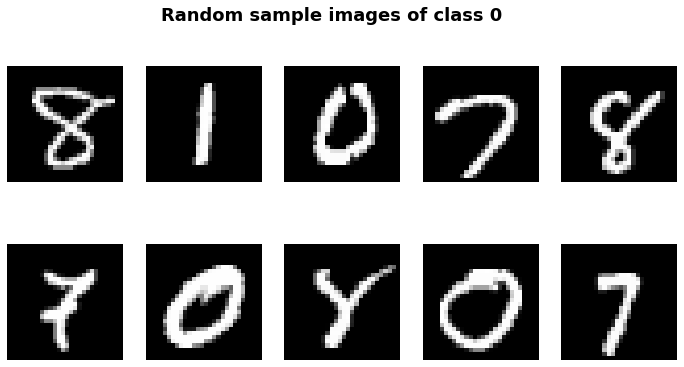

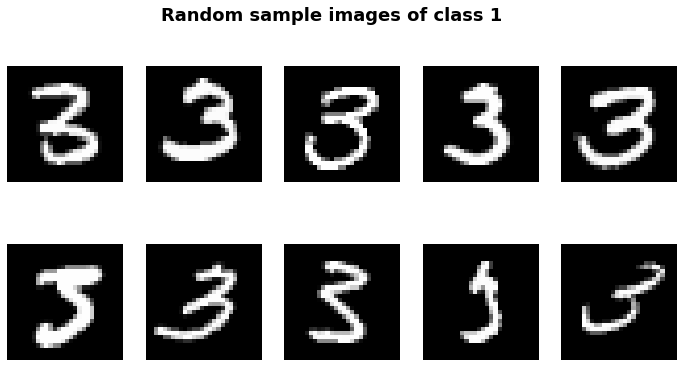

In [73]:
# reshape X test and train data to 28 x 28
Mnist_X_train1 = Mnist_X_train.reshape(Mnist_X_train.shape[0], 28, 28)
Mnist_X_test1 = Mnist_X_test.reshape(Mnist_X_test.shape[0], 28, 28)

# plot 10 random images of class 0 from the training set
fig, ax = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    ax[i // 5, i % 5].imshow(Mnist_X_train1[Mnist_y_train == 0][i], cmap="gray")
    ax[i // 5, i % 5].axis("off")
fig.suptitle("Random sample images of class 0", fontsize=18, fontweight="bold")

# plot 10 random images of class 1 from the training set
fig, ax = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    ax[i // 5, i % 5].imshow(Mnist_X_train1[Mnist_y_train == 1][i], cmap="gray")
    ax[i // 5, i % 5].axis("off")
fig.suptitle("Random sample images of class 1", fontsize=18, fontweight="bold")


#### (b).1 How many examples are present in each class? 

In [74]:
num_class0 = (Mnist_y_train == 0).sum()
num_class1 = (Mnist_y_train == 1).sum()


In [75]:
print(f"Class 0 has {num_class0} examples in the training data set")
print(f"Class 1 has {num_class1} examples in the training data set")


Class 0 has 53871 examples in the training data set
Class 1 has 6129 examples in the training data set


#### (b).2 Show bar plot by class

C:\Users\dm93\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


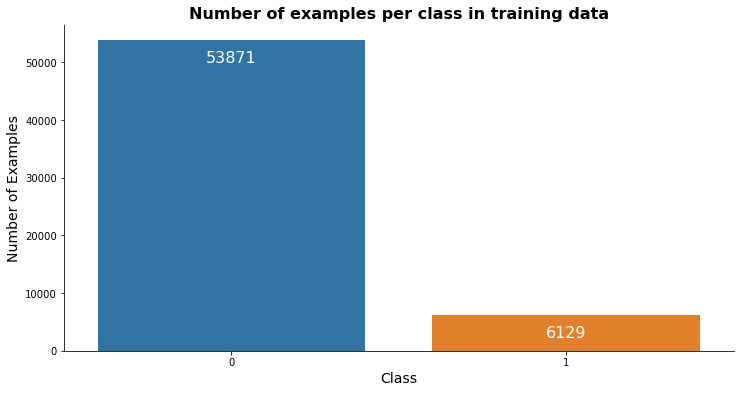

In [76]:
# bar plot by class

fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(Mnist_y_train, ax=ax)
ax.text(
    1,
    num_class1 - 3000,
    num_class1,
    fontsize=16,
    ha="center",
    va="center",
    color="white",
)
ax.text(
    0,
    num_class0 - 3000,
    num_class0,
    fontsize=16,
    ha="center",
    va="center",
    color="white",
)
ax.set_title(
    "Number of examples per class in training data", fontsize=16, fontweight="bold"
)
ax.set_xlabel("Class", fontsize=14)
ax.set_ylabel("Number of Examples", fontsize=14)
sns.despine()


#### (b).3 What fraction of samples are positive?

In [77]:
print(
    f"The proportion of positive samples in the training data set is {(num_class1/num_class0+num_class1):.2%}."
)


The proportion of positive samples in the training data set is 612911.38%.


#### (b).4 What issues might this cause?

The training data is highly imbalanced between the classes (only 10% of data is positive). Several issues arise from this:
1. Accuracy can not be trusted, because extreme cases would result in high accuracy (e.g. only 0 predicted would reach 90% accuracy).
2. Overall weaker classification power due to low positive signal.

#### (c) Using a log regression classifier, apply lasso regularization (penalty = 'l1')

In [78]:
# import metric
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score


**c.1** Plot the number of model parameters that are estimated to be nonzero (in the logistic regression model, one attribute is `coef_`, which gives you access to the model parameters for a trained model)

**c.2** Plot the cross entropy loss (which can be evaluated with the Scikit Learn `log_loss` function)

**c.3** Plot the area under the ROC curve (AUC)

**c.4** Plot the $F_1$-score (assuming a threshold of 0.5 on the predicted confidence scores, that is, scores above 0.5 are predicted as Class 1, otherwise Class 0). Scikit Learn also has a `f1_score` function which may be useful.

In [79]:
out = []  # set up
coeff_non0_all = []  # dump non-zero coefficients c1
loss_all = []  # dump cross entropy loss values c2
roc_all = []  # dump roc (AUC) c3
fl_all = []  # dump f1 scores c4
r_params = []  # keep track of parameters
C_params_range = np.logspace(-4, 4, 20)  # establish range for parameters

for i in C_params_range:
    r_params.append(i)
    model = LogisticRegression(
        penalty="l1", C=i, random_state=2018, solver="liblinear", max_iter=2000
    )
    model.fit(Mnist_X_train, Mnist_y_train)
    Mnist_y_pred = model.predict(Mnist_X_test)

    # add loss values
    c_e_loss = log_loss(Mnist_y_test, Mnist_y_pred)

    # add f1-scores
    f1 = f1_score(Mnist_y_test, Mnist_y_pred)

    # add AUCs
    roc = roc_auc_score(Mnist_y_test, model.predict_proba(Mnist_X_test)[:, 1])

    # add non-zero parameters

    coef_nonzero = len(model.coef_[0]) - list(model.coef_[0]).count(0.0)
    loss_all.append(c_e_loss)
    coeff_non0_all.append(coef_nonzero)
    fl_all.append(f1)
    roc_all.append(roc)
    pass
pass


Text(0.5, 1.0, 'Loss and regularization coefficient (C)')

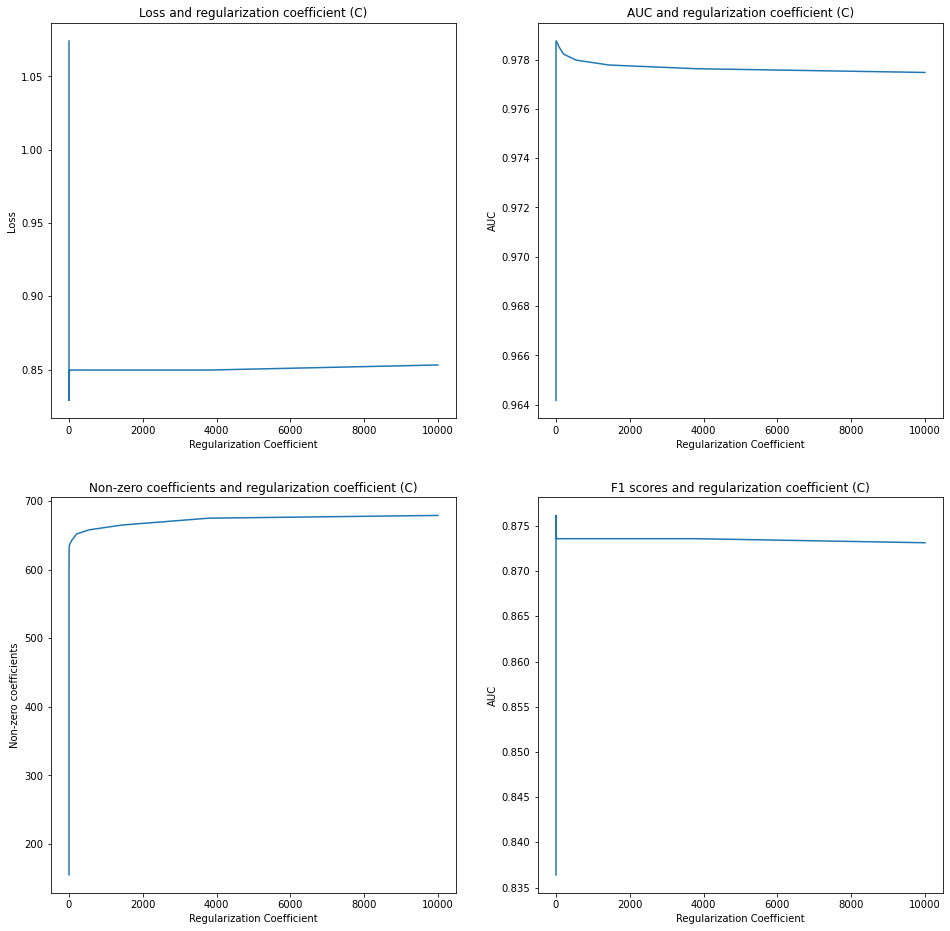

In [89]:
fig, ax = plt.subplots(2, 2, figsize=(16, 16))
ax[1, 1].plot(r_params, fl_all)
ax[1, 1].set_xlabel("Regularization Coefficient")
ax[1, 1].set_ylabel("AUC")
ax[1, 1].set_title("F1 scores and regularization coefficient (C)")
# ax[1, 1].set_xcale("log")

ax[0, 1].plot(r_params, roc_all)
ax[0, 1].set_xlabel("Regularization Coefficient")
ax[0, 1].set_ylabel("AUC")
ax[0, 1].set_title("AUC and regularization coefficient (C)")
# ax[0, 1].set_xcale("log")

ax[1, 0].plot(r_params, coeff_non0_all)
ax[1, 0].set_xlabel("Regularization Coefficient")
ax[1, 0].set_ylabel("Non-zero coefficients")
ax[1, 0].set_title("Non-zero coefficients and regularization coefficient (C)")
# ax[1, 0].set_xcale("log")

ax[0, 0].plot(r_params, loss_all)
ax[0, 0].set_xlabel("Regularization Coefficient")
ax[0, 0].set_ylabel("Loss")
ax[0, 0].set_title("Loss and regularization coefficient (C)")
# ax[0, 0].set_xcale("log")


**c.5** Which value of C seems best for this problem? Please select the closest power of 10. You will use this in the next part of this exercise.

The best overall value of C for this problem seems to be 1e-01, i.e. 0.1, where cross entropy loss and non-zero coefficients are minimized, while AUC and F1-scores are maximized. This will be the regularization value I will use in the LASSO logistic regression model in the next part of the exercise.

#### (d) Train and test four different classifiers

##### (1) logistic regression classifier with minimal regularization

In [81]:
# import kits
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# fit model log regression with min reg
logistic_min = LogisticRegression(
    random_state=2018,
    penalty="l1",
    solver="liblinear",
    C=1e100,  # use liblinear to make model converge
).fit(Mnist_X_train, Mnist_y_train)

# define metrics
y_pred_proba_min = logistic_min.predict_proba(Mnist_X_test)[
    ::, 1
]  # predicted probabilities
fpr_min, tpr_min, _ = metrics.roc_curve(
    Mnist_y_test, y_pred_proba_min
)  # false and true positive rates
auc_min = np.round(metrics.roc_auc_score(Mnist_y_test, y_pred_proba_min), 3)  # AUC
precision_min, recall_min, _ = metrics.precision_recall_curve(
    Mnist_y_test, y_pred_proba_min
)  # precision and recall


##### (2) logistic regression classifier with best value of the regularization parameter

In [82]:
# fit model log regression with best reg
logistic_best = LogisticRegression(
    random_state=2018, penalty="l1", solver="liblinear", C=1e-01
).fit(Mnist_X_train, Mnist_y_train)

# define metrics
y_pred_proba_best = logistic_best.predict_proba(Mnist_X_test)[::, 1]
fpr_best, tpr_best, _ = metrics.roc_curve(Mnist_y_test, y_pred_proba_best)
auc_best = np.round(metrics.roc_auc_score(Mnist_y_test, y_pred_proba_best), 3)
precision_best, recall_best, _ = metrics.precision_recall_curve(
    Mnist_y_test, y_pred_proba_best
)


##### (3) LDA classifier

In [83]:
# fit model with linear discriminant analysis
lda = LinearDiscriminantAnalysis().fit(Mnist_X_train, Mnist_y_train)

# define metrics
y_pred_proba_lda = lda.predict_proba(Mnist_X_test)[::, 1]
fpr_lda, tpr_lda, _ = metrics.roc_curve(Mnist_y_test, y_pred_proba_lda)
auc_lda = np.round(metrics.roc_auc_score(Mnist_y_test, y_pred_proba_lda), 3)
precision_lda, recall_lda, _ = metrics.precision_recall_curve(
    Mnist_y_test, y_pred_proba_lda
)


##### (4) RF classifier

In [84]:
# fit model with rf
rf = RandomForestClassifier(random_state=2018).fit(Mnist_X_train, Mnist_y_train)

# define metrics
y_pred_proba_rf = rf.predict_proba(Mnist_X_test)[::, 1]
fpr_rf, tpr_rf, _ = metrics.roc_curve(Mnist_y_test, y_pred_proba_rf)
auc_rf = np.round(metrics.roc_auc_score(Mnist_y_test, y_pred_proba_rf), 3)
precision_rf, recall_rf, _ = metrics.precision_recall_curve(
    Mnist_y_test, y_pred_proba_rf
)


##### Compare classifier performance using ROC and PR curves

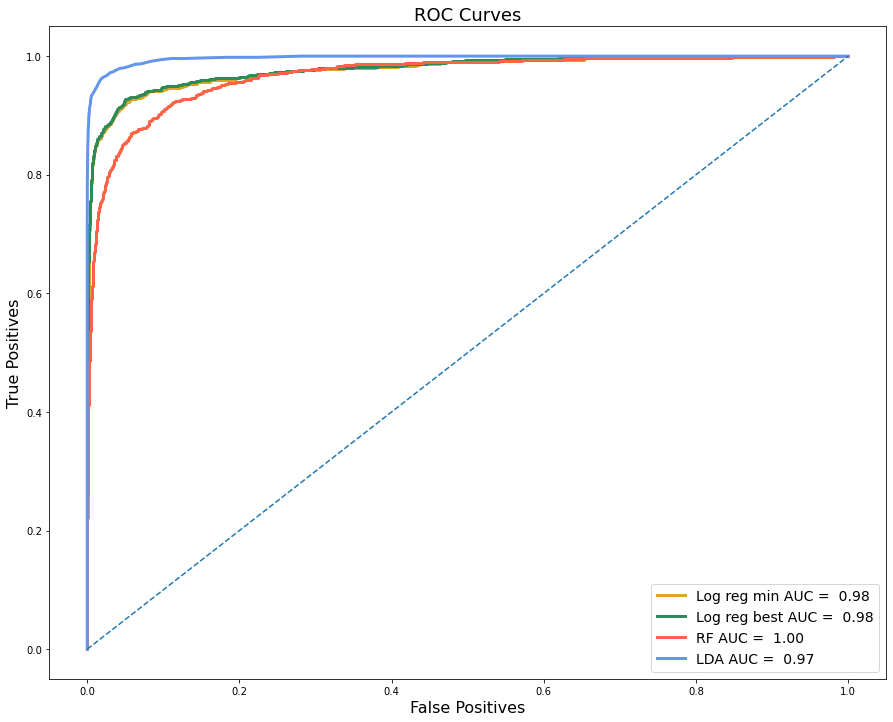

In [85]:
fig, ax = plt.subplots(figsize=(15, 12))  # setup figure
ax.plot(
    fpr_min,
    tpr_min,
    label="Logistic regression with low penalty of $c=1 \\times 10^{100}$",
    color="goldenrod",
    linewidth=3.0,
)
ax.plot(
    fpr_best,
    tpr_best,
    label="Logistic regression with ideal penalty of $c=1 \\times 10^{0.1}$",
    color="seagreen",
    linewidth=3.0,
)
ax.plot(
    fpr_lda,
    tpr_lda,
    label="Linear Discriminant Analysis",
    color="tomato",
    linewidth=3.0,
)
ax.plot(fpr_rf, tpr_rf, label="Random Forest", color="cornflowerblue", linewidth=3.0)

ax.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), "--", label="50% random guess")
ax.legend(["Log reg min AUC = {0: .2f}".format(auc_min), "Log reg best AUC = {0: .2f}".format(auc_best), "RF AUC = {0: .2f}".format(auc_rf), "LDA AUC = {0: .2f}".format(auc_lda)], loc=4, fontsize=14)
ax.set_xlabel("False Positives", fontsize=16)
ax.set_ylabel("True Positives", fontsize=16)
ax.set_title("ROC Curves", fontsize=18)
plt.show()


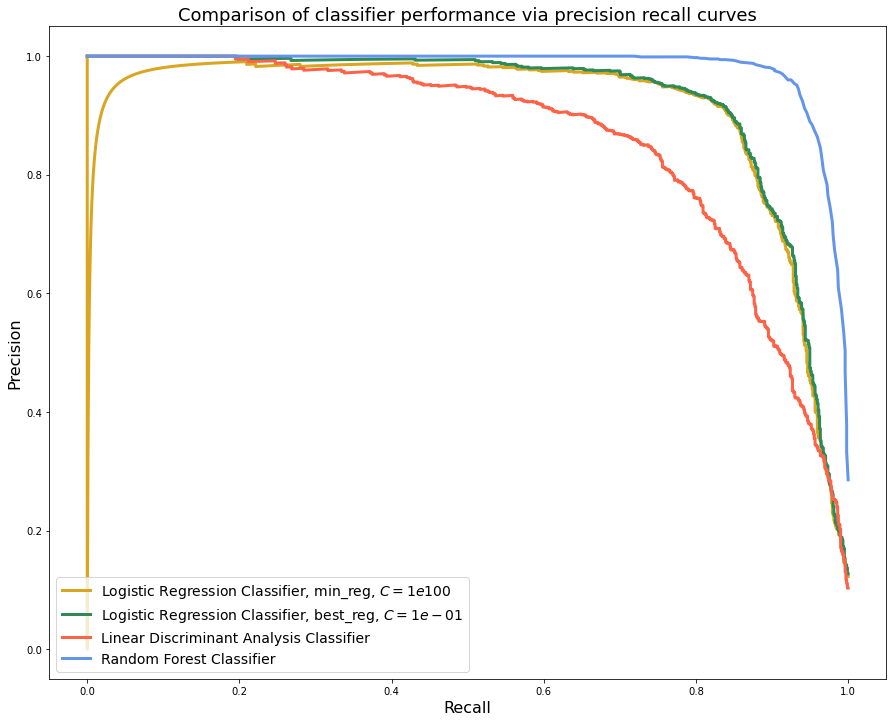

In [86]:
# make the PR curve
plt.figure(figsize=(15, 12))
plt.title("Comparison of classifier performance via precision recall curves", size=18)

plt.plot(
    recall_min,
    precision_min,
    label="Logistic Regression Classifier, min_reg, $C=1e100$",
    color="goldenrod",
    linewidth=3.0,
)
plt.plot(
    recall_best,
    precision_best,
    label="Logistic Regression Classifier, best_reg, $C=1e-01$",
    color="seagreen",
    linewidth=3.0,
)
plt.plot(
    recall_lda,
    precision_lda,
    label="Linear Discriminant Analysis Classifier",
    color="tomato",
    linewidth=3.0,
)
plt.plot(
    recall_rf,
    precision_rf,
    label="Random Forest Classifier",
    color="cornflowerblue",
    linewidth=3.0,
)

plt.ylabel("Precision", size=16)
plt.xlabel("Recall", size=16)
plt.legend(loc=3, fontsize=14)
plt.show()


#### Describe the performance of the classifiers you compared. Did the regularization of the logistic regression model make much difference here? Which classifier you would select for application to unseen data.

The best performance is seen with the random forest classifier when plotting both the ROC and the precision recall curves. The worst performance is seen with the linear discriminant analysis classifier. Both of the logistic regression models show almost exactly the same performance when plotting the ROC and precision recall curves, so the regularization does not seem to have made a big difference. The random forest classifier seems to have good flexibility and less likelihood to overfit. I would thus choose the random forest model for unseen data in this case.